In [1]:
!pip install tf-keras-vis

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

device = '/device:GPU:0' 

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

0 GPUs


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ln -s "/content/gdrive/My Drive" "/content/mydrive"

In [5]:
### Let's start with VGG, because its simple to understand, we use it in CrossView, and that's the style of model I was building to do cifar10.
### Compared to the models I was building 2C2D -> 4C2D, VGG16 is a beast with 5C3D!! But it does start with much larger images with many more pixels. 
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
# model = Model(weights=None, include_top=True, input_shape=(32,32,3), classes=10)
model = Model(weights='imagenet', include_top=True)
model.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [6]:
import pickle

# with open('/content/mydrive/imagenet_class_names.pickle', 'wb') as handle:
#     pickle.dump(imagenet_class_names, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/mydrive/imagenet_class_names.pickle', 'rb') as handle:
    imagenet_class_names = pickle.load(handle)

In [30]:
imagenet_class_names

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

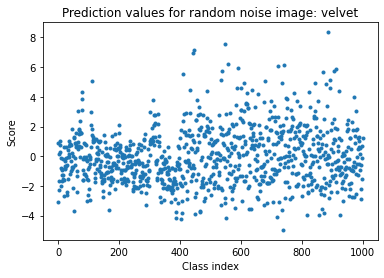

In [40]:
seed_input = tf.random.uniform((1, 224, 224, 3), 0, 255)
pred=model(seed_input)
noise_pred=pred[0]
plt.plot(noise_pred,'.')
plt.title('Prediction values for random noise image: '+imagenet_class_names[np.argmax(noise_pred)])
plt.xlabel('Class index')
plt.ylabel('Score')
plt.show()

Saliecy Maps and Attention

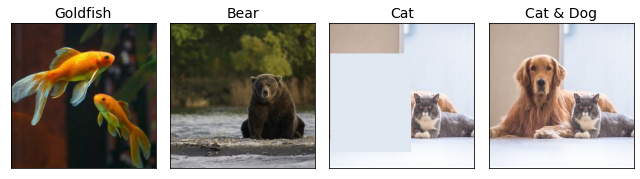

In [64]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
# Load images
img1 = load_img('/content/mydrive/images/goldfish.jpg', target_size=(224, 224))
img2 = load_img('/content/mydrive/images/bear.jpg', target_size=(224, 224))
# img3 = load_img('/content/mydrive/images/soldiers.jpg', target_size=(224, 224))
img3 = load_img('/content/mydrive/images/cat.jpg', target_size=(224, 224))
img4 = load_img('/content/mydrive/images/catdog.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Image titles
image_titles = ['Goldfish', 'Bear', 'Cat', 'Cat & Dog']

# Prepare input data
X = preprocess_input(images)

# Render
subplot_args = {
    'nrows': 1,
    'ncols': 4,
    'figsize': (9, 3),
    'subplot_kw': {'xticks': [], 'yticks': []}
}
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

In [81]:
# imagenet_class_names[np.argmax(pred4[0])].split(',')[1]
image_titles[3]+' called '+imagenet_class_names[np.argmax(pred4[0])].split(',')[1]

'Cat & Dog called  clumber spaniel'

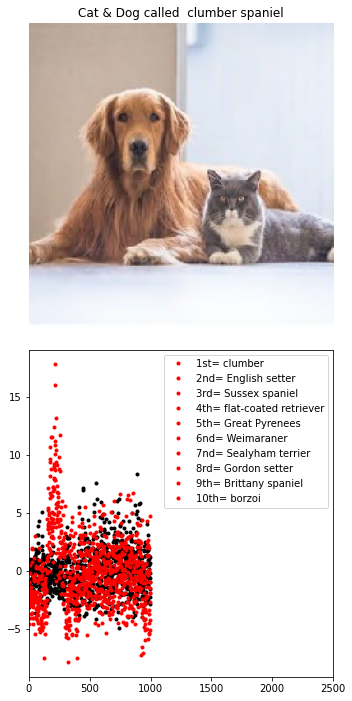

In [86]:
### It seems to see 10 possible types of dog, but no cat... hmm.
fig,ax=plt.subplots(2,1,figsize=(5,10))
ax[0].imshow(img4)
ax[0].axis('off')
pred4=model(tf.expand_dims(images[3],0))
ax[0].set_title(image_titles[3]+' called '+imagenet_class_names[np.argmax(pred4[0])].split(',')[1])
img4_top5=list(np.array(pred4[0]).argsort()[-10:])
img4_top5.reverse()
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(noise_pred,'.',color='k')
ax[1].plot(pred4[0],'.',color='r')
ax[1].legend(['1st= '+imagenet_class_names[img4_top5[0]].split(',',1)[0],
                '2nd= '+imagenet_class_names[img4_top5[1]].split(',',1)[0],
                '3rd= '+imagenet_class_names[img4_top5[2]].split(',',1)[0],
                '4th= '+imagenet_class_names[img4_top5[3]].split(',',1)[0],
                '5th= '+imagenet_class_names[img4_top5[4]].split(',',1)[0],
                '6nd= '+imagenet_class_names[img4_top5[5]].split(',',1)[0],
                '7nd= '+imagenet_class_names[img4_top5[6]].split(',',1)[0],
                '8rd= '+imagenet_class_names[img4_top5[7]].split(',',1)[0],
                '9th= '+imagenet_class_names[img4_top5[8]].split(',',1)[0],
                '10th= '+imagenet_class_names[img4_top5[9]].split(',',1)[0]])
ax[1].set_xlim([0,2500])
plt.tight_layout()
plt.show()

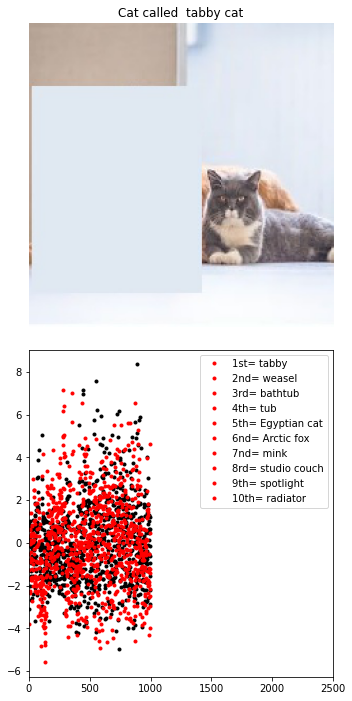

In [85]:
### It seems to see 10 possible types of dog, but no cat... hmm.
fig,ax=plt.subplots(2,1,figsize=(5,10))
ax[0].imshow(img3)
ax[0].axis('off')
pred3=model(tf.expand_dims(images[2],0))
ax[0].set_title(image_titles[2]+' called '+imagenet_class_names[np.argmax(pred3[0])].split(',')[1])
img3_top5=list(np.array(pred3[0]).argsort()[-10:])
img3_top5.reverse()
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(10,0,'.',color='r')
ax[1].plot(noise_pred,'.',color='k')
ax[1].plot(pred3[0],'.',color='r')
ax[1].legend(['1st= '+imagenet_class_names[img3_top5[0]].split(',',1)[0],
                '2nd= '+imagenet_class_names[img3_top5[1]].split(',',1)[0],
                '3rd= '+imagenet_class_names[img3_top5[2]].split(',',1)[0],
                '4th= '+imagenet_class_names[img3_top5[3]].split(',',1)[0],
                '5th= '+imagenet_class_names[img3_top5[4]].split(',',1)[0],
                '6nd= '+imagenet_class_names[img3_top5[5]].split(',',1)[0],
                '7nd= '+imagenet_class_names[img3_top5[6]].split(',',1)[0],
                '8rd= '+imagenet_class_names[img3_top5[7]].split(',',1)[0],
                '9th= '+imagenet_class_names[img3_top5[8]].split(',',1)[0],
                '10th= '+imagenet_class_names[img3_top5[9]].split(',',1)[0]])
ax[1].set_xlim([0,2500])
plt.tight_layout()
plt.show()

In [88]:
# Define loss function.
# The `output` variable refer to the output of the model,
# So, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
def loss(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    return (output[0][1], output[1][294], output[2][img3_top5[0]], output[3][img4_top5[0]])

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

In [89]:
### Vanilla Gradient ###

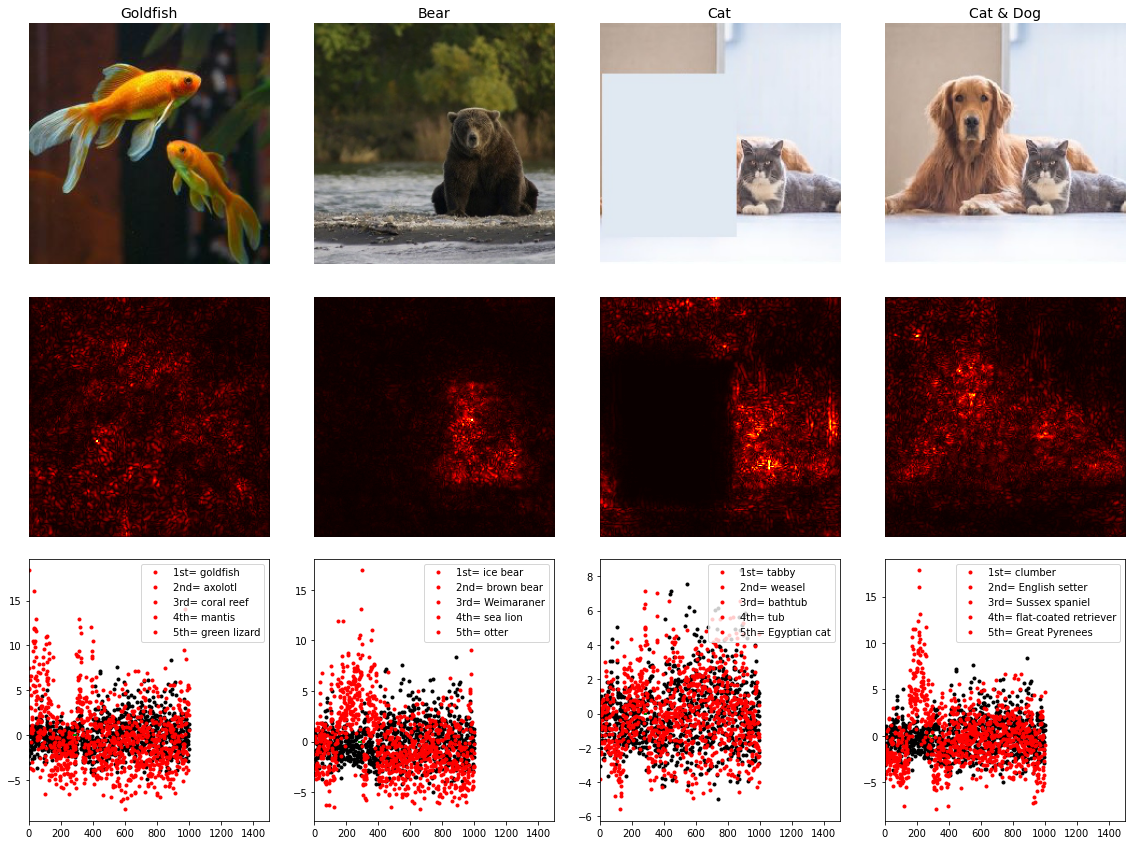

CPU times: user 21.4 s, sys: 353 ms, total: 21.8 s
Wall time: 12.6 s


In [90]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object.
# If `clone` is True(default), the `model` will be cloned,
# so the `model` instance will be NOT modified, but it takes a lot machine resources.
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

# Generate saliency map
saliency_map = saliency(loss, X)
saliency_map = normalize(saliency_map)

# Render
subplot_args = {
    'nrows': 3,
    'ncols': 4,
    'figsize': (16, 12)}
    # 'subplot_kw': {'xticks': [], 'yticks': []}

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[0,i].set_title(title, fontsize=14)
    ax[0,i].imshow(images[i])
    ax[0,i].axis('off')
    # ax[1,i].set_title(title, fontsize=14)
    ax[1,i].imshow(saliency_map[i], cmap='hot')
    ax[1,i].axis('off')
    pred=model(tf.expand_dims(images[i],0))
    top5=list(np.array(pred[0]).argsort()[-5:])
    top5.reverse()
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(noise_pred,'.',color='k')
    # ax[2,i].plot(num,pred[0][num],'o',color='g')
    ax[2,i].plot(pred[0],'.',color='r')
    ax[2,i].legend(['1st= '+imagenet_class_names[top5[0]].split(',',1)[0],
                    '2nd= '+imagenet_class_names[top5[1]].split(',',1)[0],
                    '3rd= '+imagenet_class_names[top5[2]].split(',',1)[0],
                    '4th= '+imagenet_class_names[top5[3]].split(',',1)[0],
                    '5th= '+imagenet_class_names[top5[4]].split(',',1)[0]])
    ax[2,i].plot([281,293],[0,0],'-',color='green',linewidth=2)
    ax[2,i].set_xlim([0,1500])

plt.tight_layout()
plt.savefig('/content/mydrive/images/vanilla-saliency.png')
plt.show()

In [11]:
### SmoothGrad ###

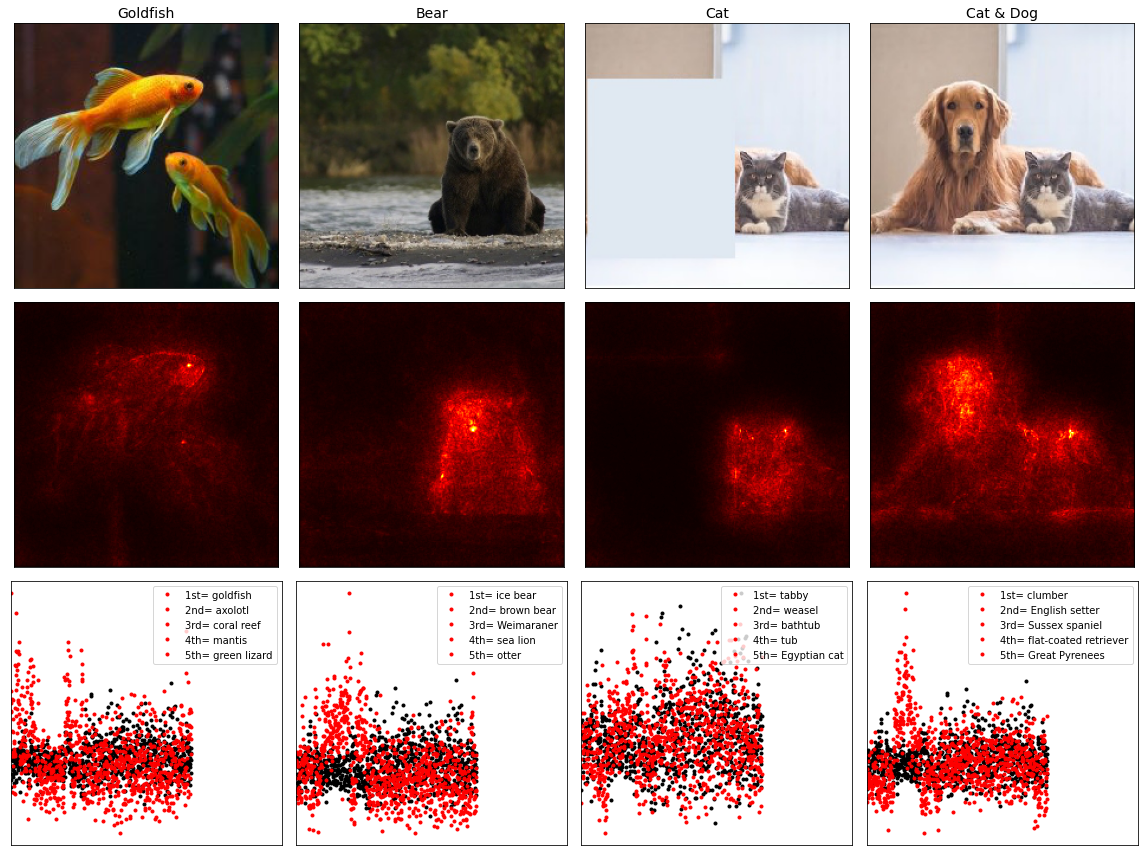

CPU times: user 5min 11s, sys: 3.62 s, total: 5min 14s
Wall time: 2min 48s


In [91]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = normalize(saliency_map)


# Render
subplot_args = {
    'nrows': 3,
    'ncols': 4,
    'figsize': (16, 12),
    'subplot_kw': {'xticks': [], 'yticks': []}}

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[0,i].set_title(title, fontsize=14)
    ax[0,i].imshow(images[i])
    # ax[1,i].set_title(title, fontsize=14)
    ax[1,i].imshow(saliency_map[i], cmap='hot')
    pred=model(tf.expand_dims(images[i],0))
    top5=list(np.array(pred[0]).argsort()[-5:])
    top5.reverse()
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(10,0,'.',color='r')
    ax[2,i].plot(noise_pred,'.',color='k')
    # ax[2,i].plot(num,pred[0][num],'o',color='g')
    ax[2,i].plot(pred[0],'.',color='r')
    ax[2,i].legend(['1st= '+imagenet_class_names[top5[0]].split(',',1)[0],
                    '2nd= '+imagenet_class_names[top5[1]].split(',',1)[0],
                    '3rd= '+imagenet_class_names[top5[2]].split(',',1)[0],
                    '4th= '+imagenet_class_names[top5[3]].split(',',1)[0],
                    '5th= '+imagenet_class_names[top5[4]].split(',',1)[0]])
    ax[2,i].set_xlim([0,1500])

plt.tight_layout()
plt.savefig('/content/mydrive/images/smooth-saliency.png')
plt.show()

In [13]:
#### GradCAM ####

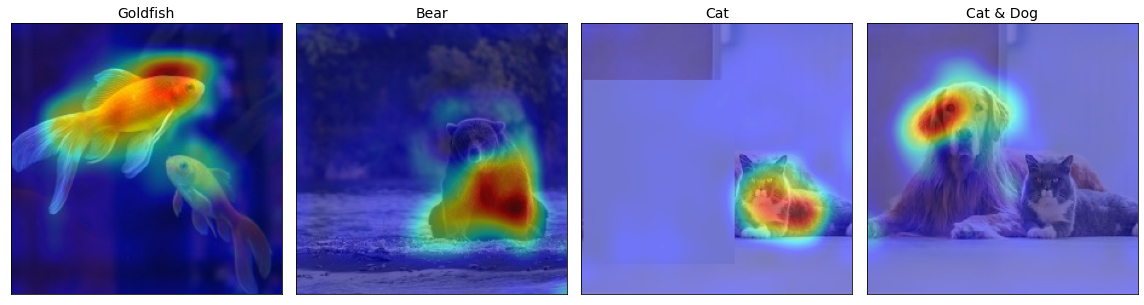

CPU times: user 15.8 s, sys: 336 ms, total: 16.1 s
Wall time: 8.84 s


In [94]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
              seek_penultimate_conv_layer=True, # If True(default), to seek the penultimate layter that is a subtype of Convolutional Layer
              normalize_gradient=False)
cam = normalize(cam)

subplot_args = {
    'nrows': 1,
    'ncols': 4,
    'figsize': (16, 8),
    'subplot_kw': {'xticks': [], 'yticks': []}
}

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    # heatmap = np.uint8(cm.hot(cam[i])[..., :3] * 255)
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    # ax[i].imshow(heatmap, cmap='hot', alpha=0.5)
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
# plt.savefig('images/gradcam.png')
plt.show()

In [15]:
### GradCAM++ ###

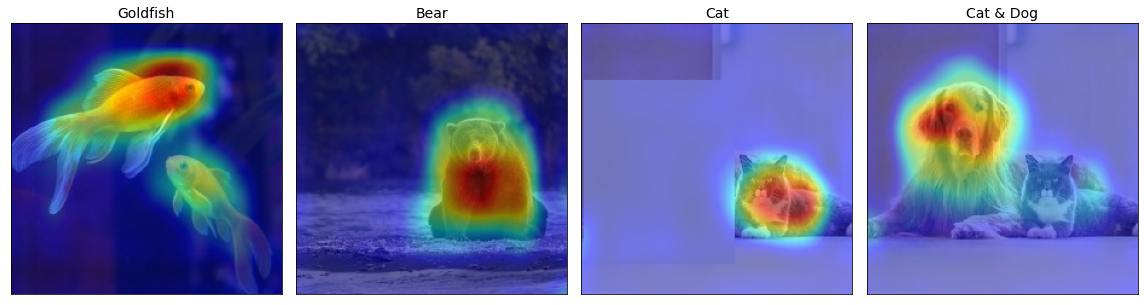

In [97]:
from tf_keras_vis.gradcam import GradcamPlusPlus

# Repalce class name to "GradcamPlusPlus"
# gradcam = Gradcam(model, model_modifier, clone=False)
gradcam = GradcamPlusPlus(model,
                          model_modifier=model_modifier,
                          clone=False)

# Generate heatmap with GradcamPlusPlus
# `normalize_gradient` is NOT supported by GradcamPlusPlus#__call__()
cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
              seek_penultimate_conv_layer=True, # If True(default), to seek the penultimate layter that is a subtype of Convolutional Layer
              # normalize_gradient=False
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    pred=model(tf.expand_dims(images[i],0))
    ax[i].set_title(image_titles[3]+' called '+imagenet_class_names[np.argmax(pred[0])].split(',')[1])
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
# plt.savefig('images/gradcam_plus_plus.png')
plt.show()

In [ ]:
### Well It looks like GradCAM and GradCAM++ can locate the dog with the cat distractor, but I'm surprised the cat score isn't higher when the dog is present. Im also surprised the cat score isn't higher when the dog is removed.
### Final  remaining thing to try is load an untrained model with random weights to see that predictions and saliency maps become nonsense, and don't jst continue to see the objects due to the image input itself. 
